In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style="white", context="notebook", palette="deep")

pd.options.mode.copy_on_write = True

In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
IDtest = test["PassengerId"]

2.2 Outlier detection

In [4]:
def detect_outliers(df, n, features):
    
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        # whisker 밖에 있는 data를 outlier로 지정
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

In [5]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

#### 2.3 joining train and test set

In [7]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

#### 2.4 check for null and missing value

In [8]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features have an important part of missing values.

Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set)
-> survived의 nan 값은 test set을 train과 병합하면서 발생한 null값이다.

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3.Feature Analysis

#### 3.1 numerical values

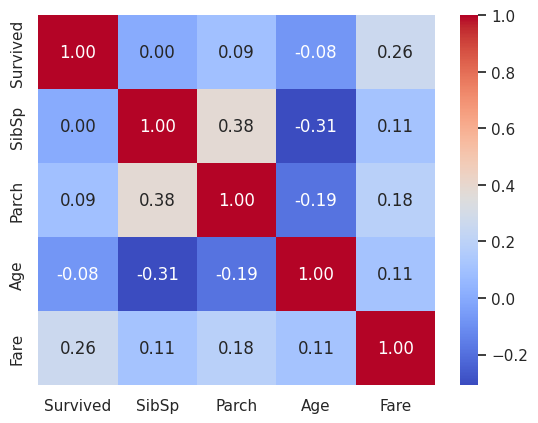

In [13]:
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features

##### SipSb

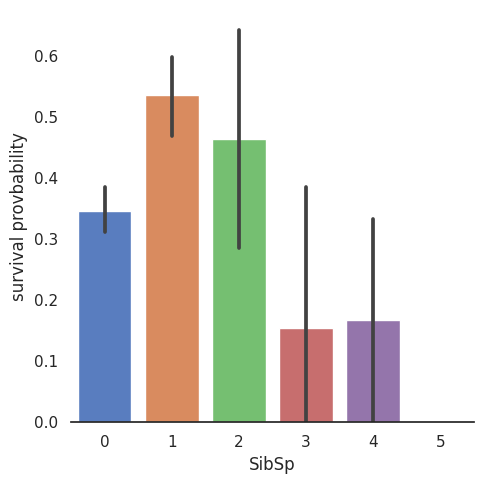

In [14]:
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", palette="muted",)
g.despine(left = True)
g = g.set_ylabels("survival provbability")

자손이 많으면 생존율이 더낮다.

##### Parch

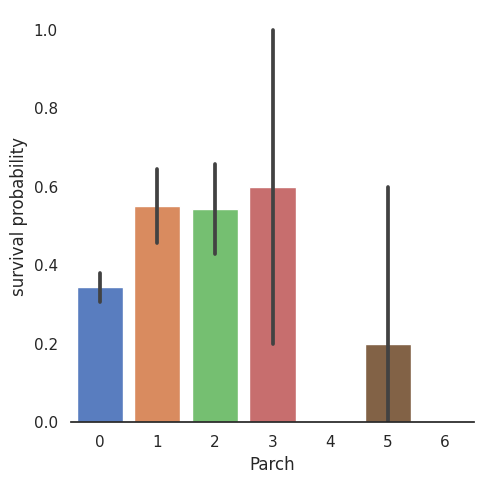

In [15]:
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

#### Age

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


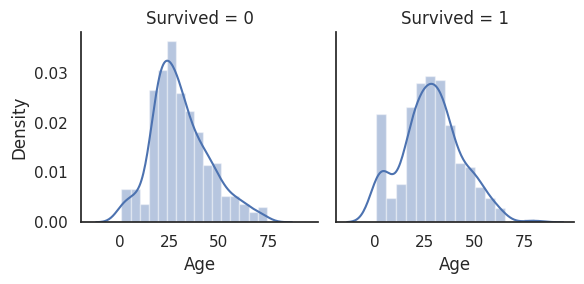

In [16]:
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")

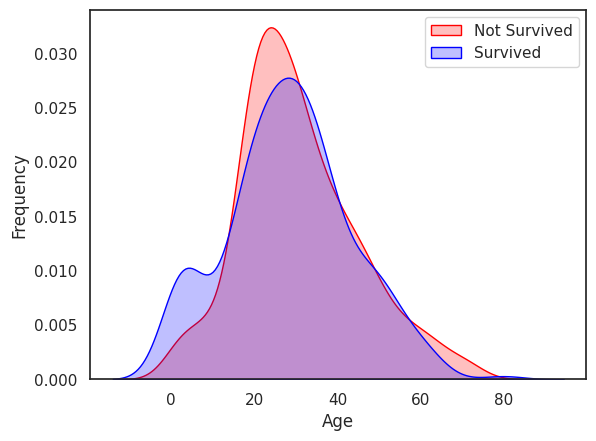

In [17]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", fill = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue", fill = True)

g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

Fare

In [18]:
dataset["Fare"].isnull().sum()

1

In [19]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

/tmp/ipykernel_42/3447854757.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))


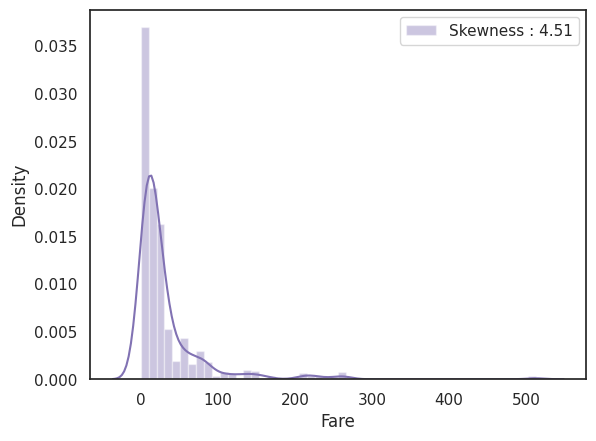

In [20]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [21]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

/tmp/ipykernel_42/846037914.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))


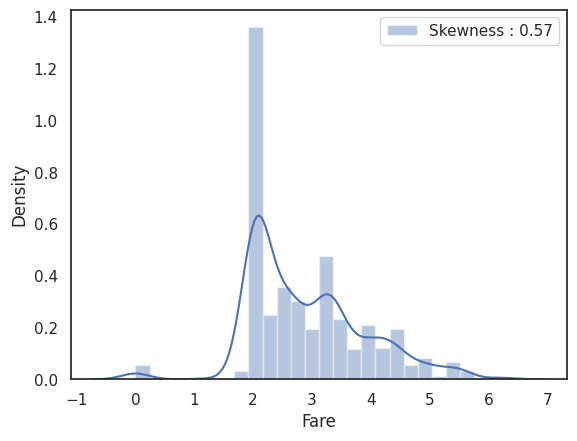

In [22]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

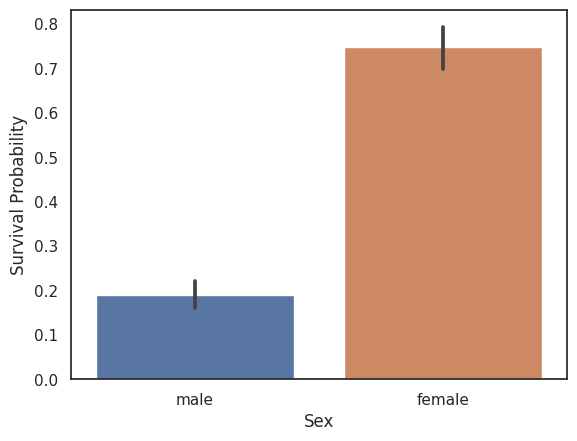

In [23]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [24]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


Pcalss

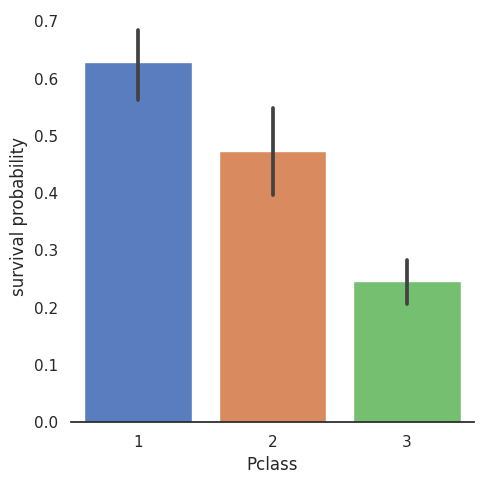

In [25]:
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", palette="muted")
g.despine(left=True) # y축 라인을 제거
g = g.set_ylabels("survival probability")

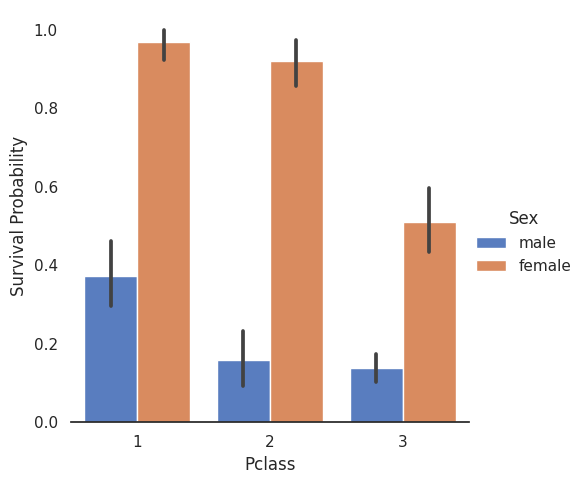

In [26]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar", palette="muted")
g.despine(left = True)
g = g.set_ylabels("Survival Probability")

Embarked

In [27]:
dataset["Embarked"].isnull().sum()

2

In [28]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

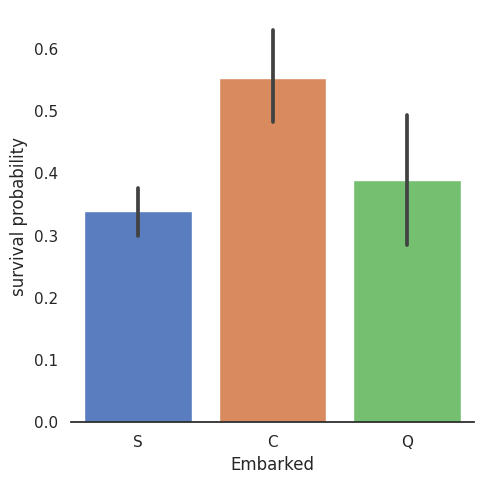

In [29]:
g = sns.catplot(x="Embarked", y="Survived", data=train, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

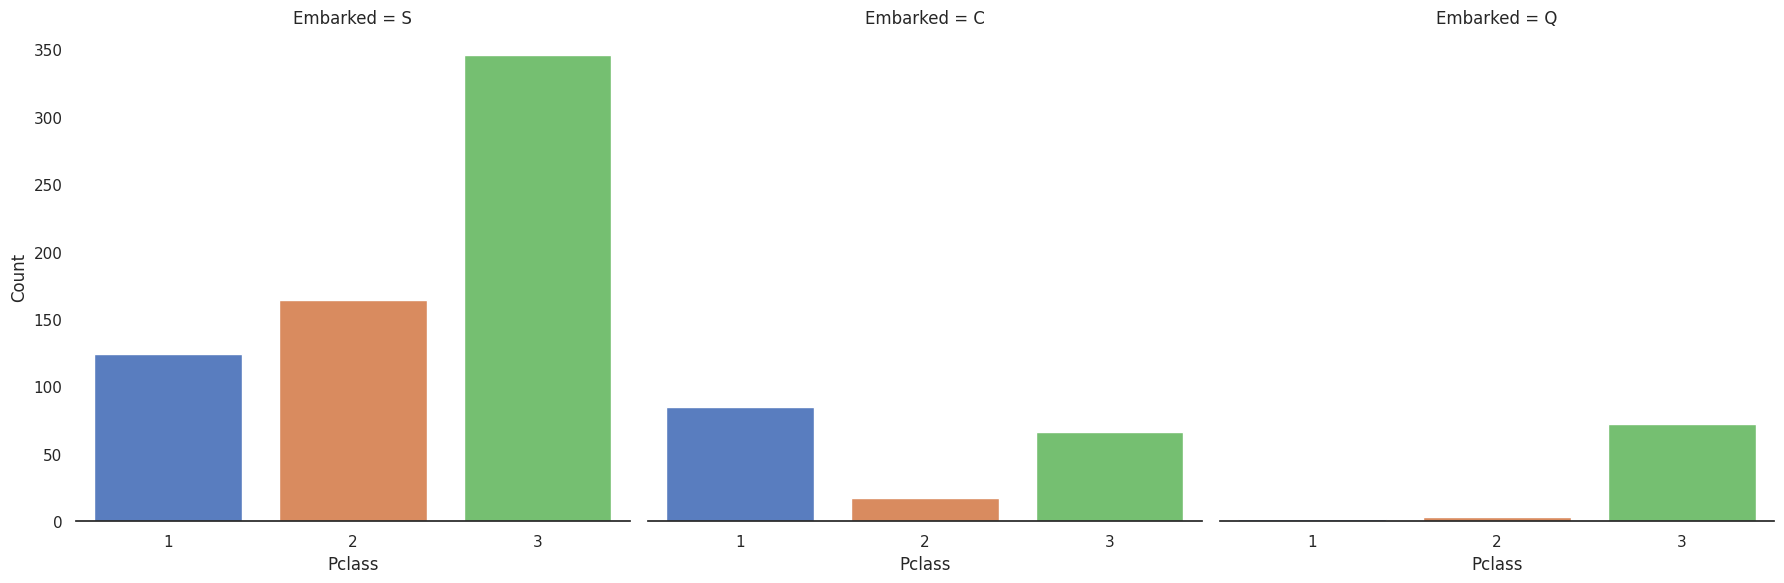

In [30]:
g = sns.catplot(x="Pclass", col="Embarked", data=train, kind="count", height=6, palette="muted")
g.set_axis_labels("Pclass", "Count")
g.despine(left=True)

plt.show()

## 4.Filling Missing Values

#### 4.1 Age

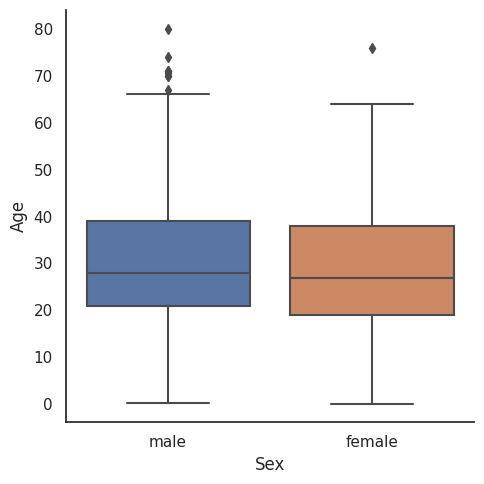

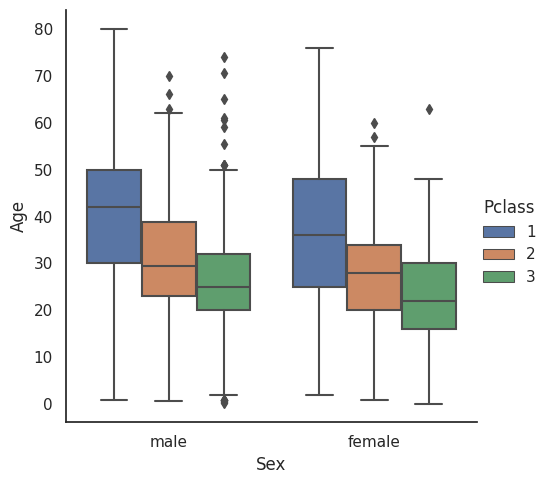

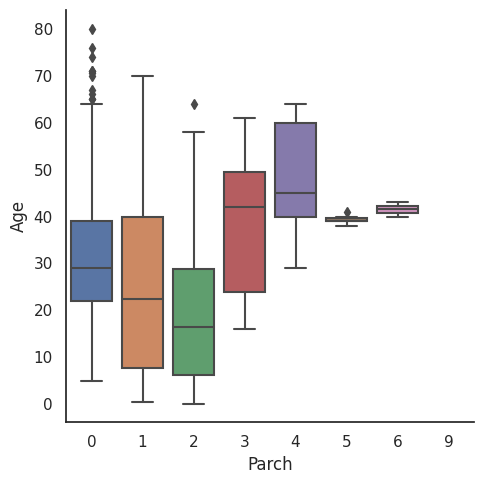

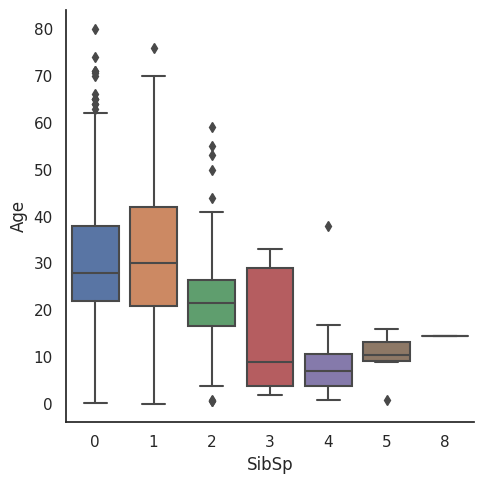

In [31]:
g = sns.catplot(x="Sex", y="Age", data=dataset, kind="box")
g = sns.catplot(x="Sex", y="Age", hue="Pclass", data=dataset, kind="box")
g = sns.catplot(x="Parch", y="Age", data=dataset, kind="box")
g = sns.catplot(x="SibSp", y="Age", data=dataset, kind="box")

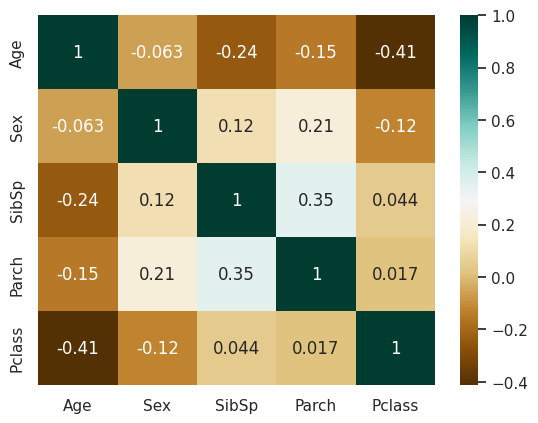

In [32]:
dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap="BrBG", annot=True)

In [33]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset.loc[((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"])), "Age"].median()
    
    if not np.isnan(age_pred):
        dataset.loc[i, 'Age'] = age_pred
    else:
        dataset.loc[i, 'Age'] = age_med


/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


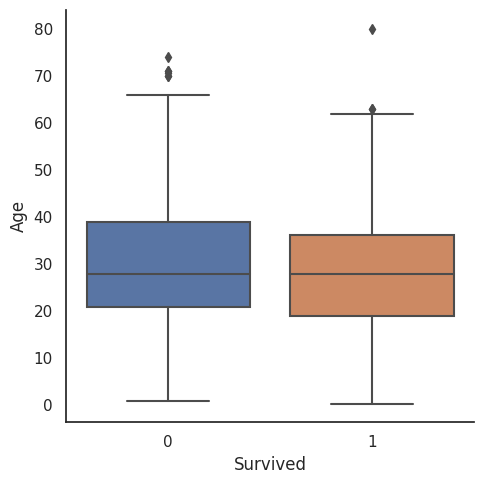

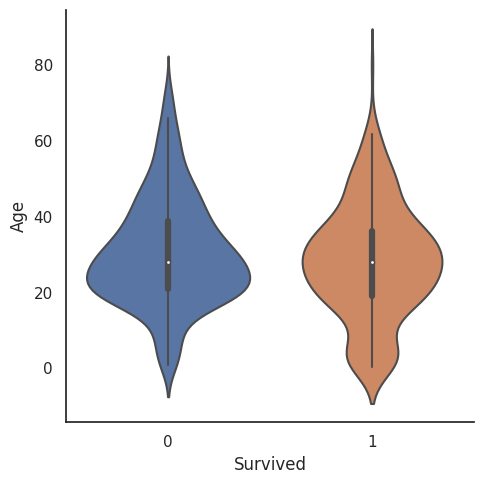

In [34]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

## 5.Feature engineering

#### 5.1 Name/Title

In [35]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [36]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

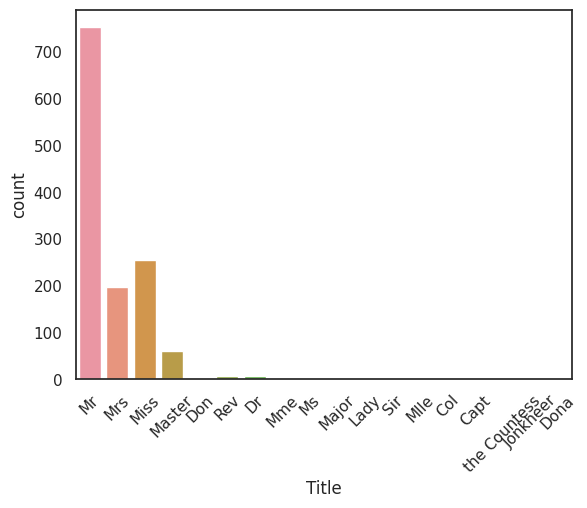

In [37]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [38]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [39]:
dataset["Title"].value_counts()

Title
2    753
1    457
0     60
3     29
Name: count, dtype: int64

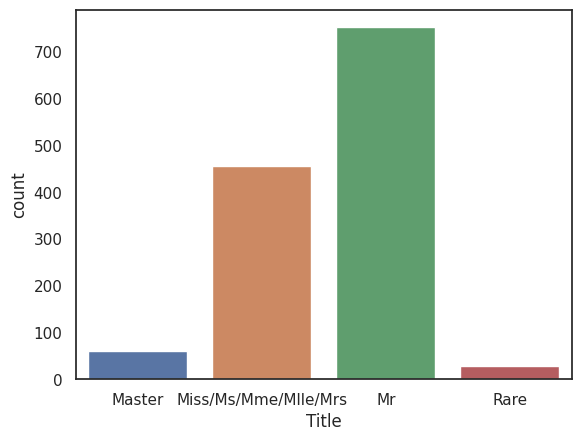

In [40]:
g = sns.countplot(x = dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

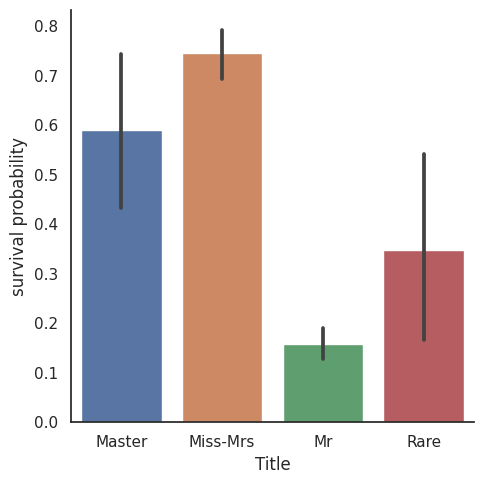

In [41]:
g = sns.catplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("survival probability")

In [42]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

#### 5.2 Family Size

In [43]:
dataset["FSize"] = dataset["SibSp"] + dataset["Parch"] + 1

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


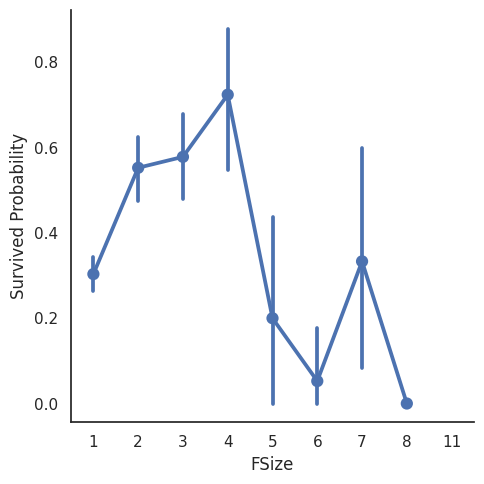

In [44]:
g = sns.catplot(x="FSize", y="Survived", data=dataset, kind="point")
g = g.set_ylabels("Survived Probability")

In [45]:
dataset['Single'] = dataset['FSize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['FSize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['FSize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['FSize'].map(lambda s: 1 if s >= 5 else 0)

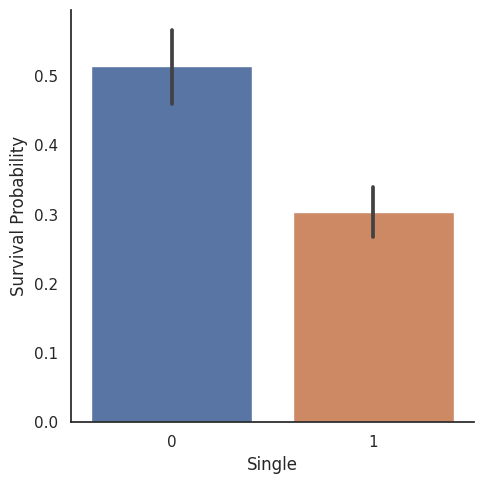

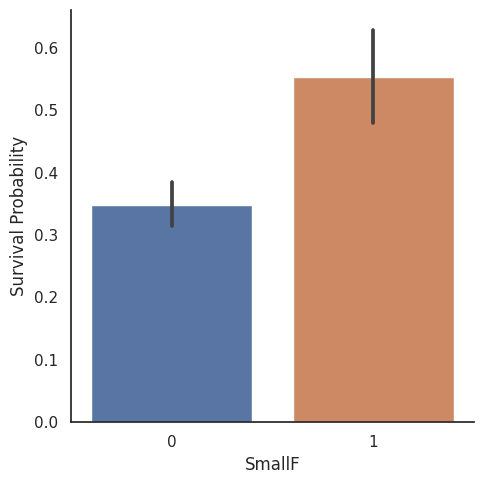

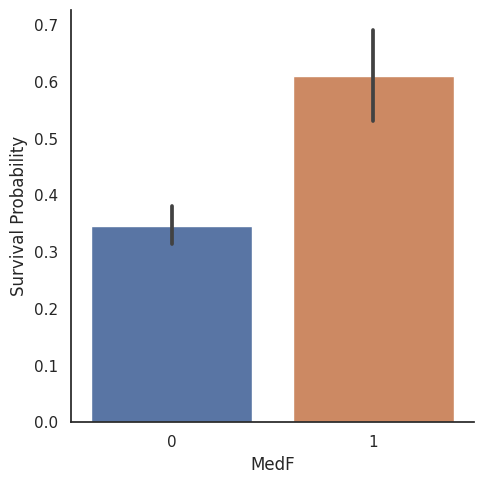

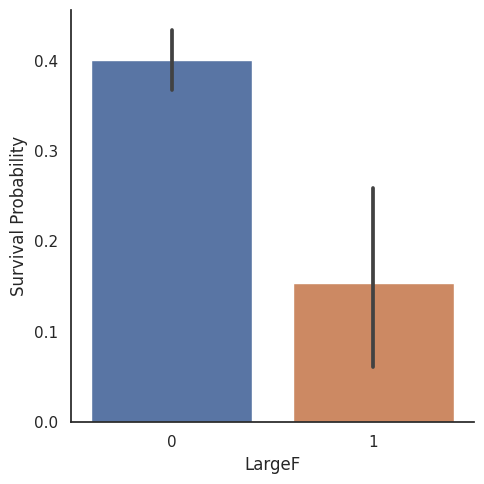

In [46]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [47]:
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [48]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


#### 5.3 Cabin

In [49]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [51]:
dataset["Cabin"].isnull().sum()

1007

In [52]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset["Cabin"]])

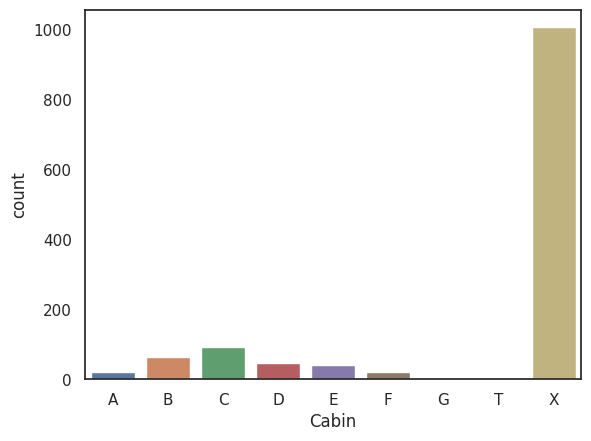

In [54]:
g = sns.countplot(x=dataset["Cabin"], order=['A','B','C','D','E','F','G','T','X'])

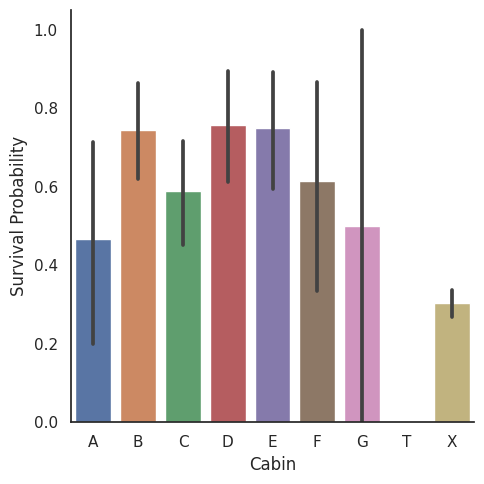

In [55]:
g = sns.catplot(y="Survived", x="Cabin", data=dataset, kind="bar", order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [56]:
dataset["Cabin"].value_counts()

Cabin
X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

In [57]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

#### 5.4 Ticket

In [58]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [59]:
Ticket = []

for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(" ")[0])
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [60]:
dataset["Ticket"].value_counts()

Ticket
X          954
PC          92
CA          61
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
C            8
SOC          8
SOPP         7
STONO2       7
SCParis      5
SCAH         5
PP           4
LINE         4
WEP          4
FC           3
SOTONO2      3
SCA4         2
SWPP         2
PPP          2
SC           2
SCA3         1
A            1
LP           1
AQ4          1
STONOQ       1
Fa           1
CASOTON      1
AS           1
SCOW         1
SOP          1
SP           1
AQ3          1
Name: count, dtype: int64

In [61]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [62]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"], prefix="Pc")

In [63]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [64]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,FSize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,False,False,False,False,False,False,False,True,False,False
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,False,True,False,False,False,False,False,False,False,True
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,False,False,False,False,False,False,True,True,False,False
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,False,False,False,False,False,False,True,False,False,True


## 6. Modeling

In [65]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace = True)

In [66]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

#### 6.1 Simple Modeling

#### 6.1.1 Cross validate models
I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [67]:
kfold = StratifiedKFold(n_splits=10)

In [68]:
random_state=2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [69]:
X_train.isna().sum()

Sex      0
Age      0
SibSp    0
Parch    0
Fare     0
        ..
T_WEP    0
T_X      0
Pc_1     0
Pc_2     0
Pc_3     0
Length: 66, dtype: int64

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

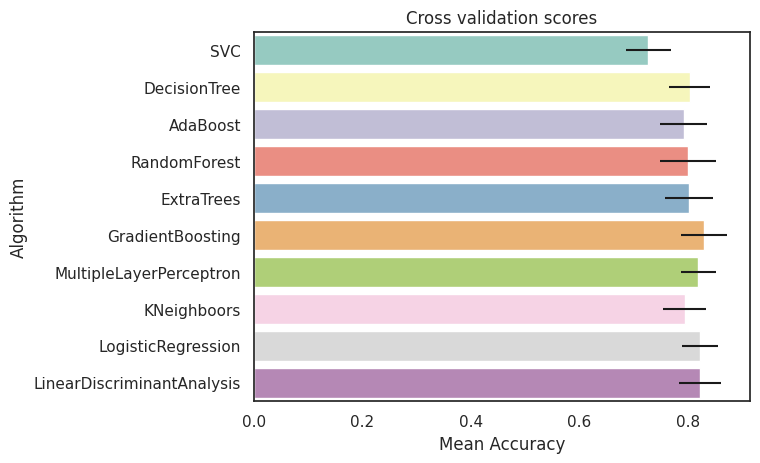

In [70]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x ="CrossValMeans",y ="Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

#### 6.1 hyperparameter tuning 

In [71]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(estimator=DTC, random_state=7)

ada_param_grid = {"algorithm": ["SAMME", "SAMME.R"],
                 "n_estimators" : [1, 2],
                 "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8093718079673137

In [72]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth":[None],
                "max_features":[1, 3, 10],
                "min_samples_split":[2, 3, 10],
                "min_samples_leaf":[1, 3, 10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}


gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, return_train_score=True, n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)
ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8331716036772218

In [73]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False],
                "n_estimators": [100, 300],
                "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.833158835546476

In [74]:
gsRFC.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300}

In [75]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['log_loss'],
                'n_estimators':[100,200,300],
                'learning_rate':[0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100,150],
                'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8320097037793668

In [76]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 Plot learning curves

In [77]:
import numpy as np

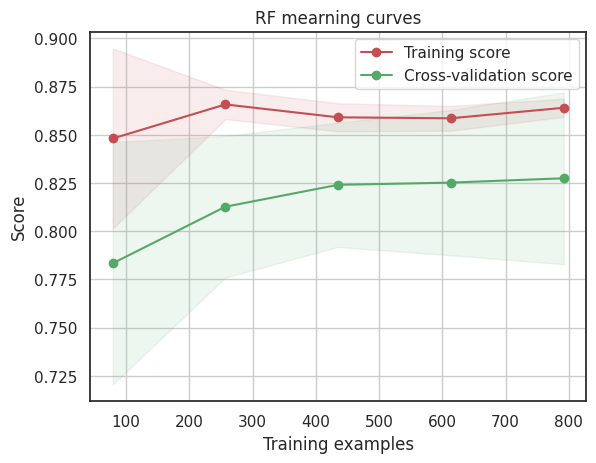

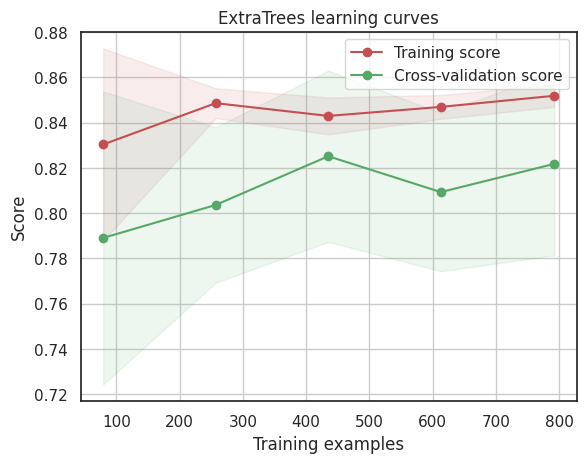

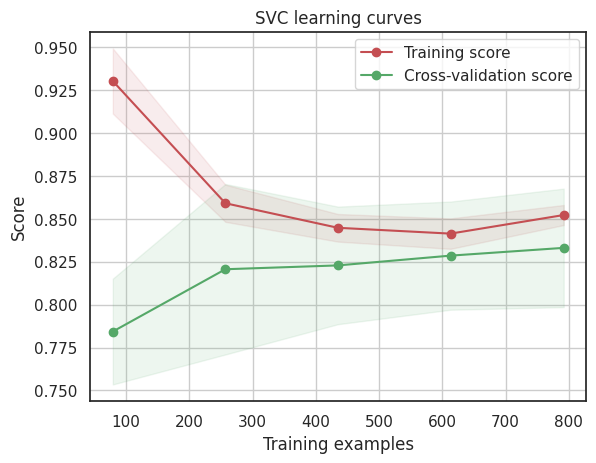

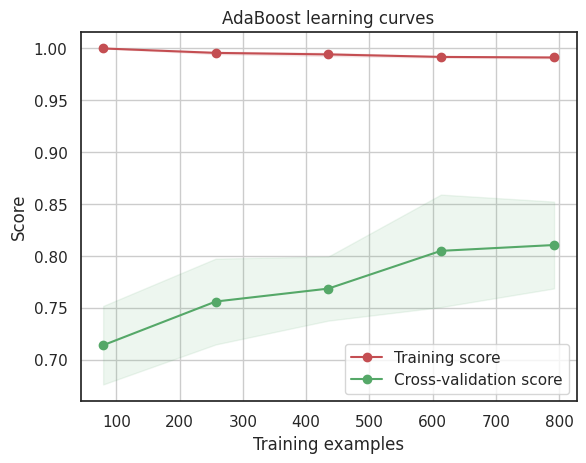

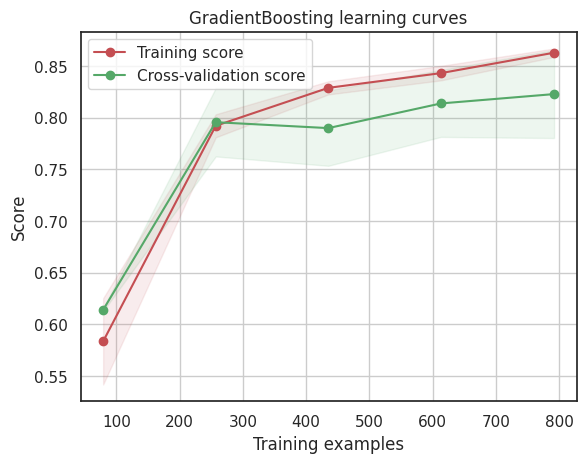

In [78]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)